In [27]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
import nltk

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

# Load stopwords
stop_words = set(stopwords.words('english'))

# Load the dataset
df = pd.read_csv('data/edu_he_merged.csv', low_memory=False)

# Focus on relevant columns
columns_to_keep = ['selftext', 'title', 'Year', 'Sentiment', 'Emotions', 'created_utc_sub', 'created_utc_com', 'ups_sub', 'downs_sub', 'ups_com', 'downs_com']
df = df[columns_to_keep]

# Drop rows with missing 'selftext' or 'title'
df.dropna(subset=['selftext', 'title'], inplace=True)

# Remove duplicates
df.drop_duplicates(subset=['selftext', 'title'], inplace=True)

# Convert the 'Year' column to numeric, coercing errors into NaN
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

# Drop rows with NaN in 'Year' if you don't need them
df.dropna(subset=['Year'], inplace=True)

# Convert the column to int now that it's cleaned
df['Year'] = df['Year'].astype(int)

# Filter out '[removed]' and '[deleted]' entries
df = df[~df['selftext'].isin(['[removed]', '[deleted]'])]

# Define a preprocessing function to clean text data
def get_wordnet_pos(treebank_tag):
    # Convert treebank POS tags to wordnet POS tags
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def preprocess_text(text):
    # Lowercase and remove special characters/numbers
    text = re.sub(r'http\S+|www\S+|\d+', '', text.lower())  # removing URLs and numbers
    text = re.sub(r'[^a-z\s]', '', text)  # keep only alphabets and spaces

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords and perform lemmatization with POS tags
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tag(tokens) if word not in stop_words]

    return tokens

# Apply preprocessing to combine selftext and title into a single text column
df['combined_text'] = (df['selftext'] + " " + df['title']).apply(preprocess_text)

# Display the first few entries of the combined text
print(df['combined_text'].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeffrey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jeffrey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jeffrey/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/jeffrey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


65     [im, second, year, high, school, science, teac...
87     [assumption, school, counselor, utilized, desp...
130    [college, year, horrendous, therefore, chance,...
172    [age, old, question, im, look, start, travel, ...
174    [im, almost, ive, college, one, semester, flun...
Name: combined_text, dtype: object


In [28]:
df.head()

,selftext,title,Year,Sentiment,Emotions,created_utc_sub,created_utc_com,ups_sub,downs_sub,ups_com,downs_com,combined_text
65,I'm in my second year as a high school science...,What journals (peer-reviewed or otherwise) do ...,2018,0.000000,joy,2018-01-01 15:25:52,1.514822e+09,NaN,NaN,NaN,NaN,"[im, second, year, high, school, science, teac..."
87,"So here are my assumptions, most school Counse...","I am trying to research on school Counselors, ...",2018,0.325000,love,2018-01-02 08:18:18,1.514886e+09,NaN,NaN,NaN,NaN,"[assumption, school, counselor, utilized, desp..."
130,"My college years were horrendous, therefore I ...",Trying to get admitted in a bachelor degree !!!,2018,0.008571,anger,2018-01-02 14:22:49,1.514904e+09,NaN,NaN,NaN,NaN,"[college, year, horrendous, therefore, chance,..."
172,The age old question... I'm looking to start u...,Formal vs. Self Education for blogging?,2018,0.396875,joy,2018-01-02 22:05:28,1.515030e+09,NaN,NaN,NaN,NaN,"[age, old, question, im, look, start, travel, ..."
174,I'm 23 almost 24. I've been to college for one...,How do I know if I'm ready for college?,2018,0.083333,joy,2018-01-03 00:00:26,1.514943e+09,NaN,NaN,NaN,NaN,"[im, almost, ive, college, one, semester, flun..."


In [29]:
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
from nltk.corpus import stopwords
import re
from nltk.stem.wordnet import WordNetLemmatizer
import nltk


# Split the data into pre-COVID and post-COVID datasets
pre_covid_df = df[df['Year'] < 2020]
post_covid_df = df[df['Year'] > 2020]

# Check if the DataFrame is empty after filtering by year
if pre_covid_df.empty:
    raise ValueError("The pre-COVID dataframe is empty. Check your data filtering criteria.")
if post_covid_df.empty:
    raise ValueError("The post-COVID dataframe is empty. Check your data filtering criteria.")

# Function to prepare the corpus for LDA
def prepare_corpus(dataframe):
    texts = dataframe['combined_text']
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    return dictionary, corpus

# Prepare the corpus
pre_covid_dictionary, pre_covid_corpus = prepare_corpus(pre_covid_df)
post_covid_dictionary, post_covid_corpus = prepare_corpus(post_covid_df)

# Train LDA models
num_topics = 6
pre_covid_lda_model = models.LdaMulticore(pre_covid_corpus, num_topics=num_topics, id2word=pre_covid_dictionary, passes=10, workers=2)
post_covid_lda_model = models.LdaMulticore(post_covid_corpus, num_topics=num_topics, id2word=post_covid_dictionary, passes=10, workers=2)

# Display the topics
print("Pre-COVID topics:")
for idx, topic in pre_covid_lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

print("\nPost-COVID topics:")
for idx, topic in post_covid_lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))


Pre-COVID topics:
Topic: 0 
Words: 0.010*"student" + 0.009*"education" + 0.009*"school" + 0.009*"im" + 0.008*"learn" + 0.008*"study" + 0.008*"class" + 0.007*"teach" + 0.007*"would" + 0.007*"college"
Topic: 1 
Words: 0.018*"student" + 0.016*"school" + 0.012*"teacher" + 0.011*"get" + 0.009*"education" + 0.008*"im" + 0.008*"year" + 0.007*"class" + 0.007*"would" + 0.007*"go"
Topic: 2 
Words: 0.012*"student" + 0.010*"school" + 0.010*"education" + 0.007*"would" + 0.007*"course" + 0.007*"high" + 0.007*"university" + 0.007*"get" + 0.006*"college" + 0.005*"im"
Topic: 3 
Words: 0.011*"student" + 0.009*"online" + 0.008*"im" + 0.008*"school" + 0.008*"degree" + 0.008*"use" + 0.007*"work" + 0.006*"program" + 0.006*"time" + 0.006*"get"
Topic: 4 
Words: 0.029*"school" + 0.015*"student" + 0.009*"college" + 0.008*"year" + 0.007*"education" + 0.006*"say" + 0.006*"major" + 0.006*"university" + 0.005*"class" + 0.005*"public"
Topic: 5 
Words: 0.020*"school" + 0.017*"im" + 0.012*"get" + 0.011*"would" + 0.009

In [23]:
from gensim.models.coherencemodel import CoherenceModel

# Function to compute coherence values
def compute_coherence_for_lda(lda_model, texts, dictionary):
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model_lda.get_coherence()

# Compute coherence for pre-COVID LDA model
pre_covid_coherence = compute_coherence_for_lda(pre_covid_lda_model, pre_covid_df['combined_text'].tolist(), pre_covid_dictionary)
print('Pre-COVID LDA Model Coherence:', pre_covid_coherence)

# Compute coherence for post-COVID LDA model
post_covid_coherence = compute_coherence_for_lda(post_covid_lda_model, post_covid_df['combined_text'].tolist(), post_covid_dictionary)
print('Post-COVID LDA Model Coherence:', post_covid_coherence)

Pre-COVID LDA Model Coherence: 0.33071643190082683
Post-COVID LDA Model Coherence: 0.3416320669258938


In [39]:
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3, passes=10, alpha='symmetric', eta='symmetric'):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                                    passes=passes, workers=2, alpha=alpha, eta=eta)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Parameters
topic_range = range(2, 15, 2)  # Example range from 2 to 14 topics
alpha_values = [0.01, 0.1, 'symmetric', 'asymmetric']
eta_values = [0.01, 0.1, 'symmetric']

# Store results
results = {}

# Test various hyperparameters
for alpha in alpha_values:
    for eta in eta_values:
        _, coherence_scores = compute_coherence_values(dictionary=pre_covid_dictionary, corpus=pre_covid_corpus,
                                                       texts=pre_covid_df['combined_text'].tolist(), limit=15,
                                                       start=2, step=2, passes=10, alpha=alpha, eta=eta)
        results[(alpha, eta)] = coherence_scores

# Print results
for params, scores in results.items():
    alpha, eta = params
    for num_topics, score in zip(topic_range, scores):
        print(f"Alpha: {alpha}, Eta: {eta}, Topics: {num_topics}, Coherence: {score:.4f}")

# Select the model with the highest coherence
best_params = max(results, key=lambda x: max(results[x]))
best_alpha, best_eta = best_params
best_score = max(results[best_params])
best_topic_num = topic_range[results[best_params].index(best_score)]

print(f"Best Model: {best_topic_num} topics, Alpha: {best_alpha}, Eta: {best_eta}, Coherence: {best_score}")


Alpha: 0.01, Eta: 0.01, Topics: 2, Coherence: 0.3443
Alpha: 0.01, Eta: 0.01, Topics: 4, Coherence: 0.3392
Alpha: 0.01, Eta: 0.01, Topics: 6, Coherence: 0.3388
Alpha: 0.01, Eta: 0.01, Topics: 8, Coherence: 0.3328
Alpha: 0.01, Eta: 0.01, Topics: 10, Coherence: 0.3132
Alpha: 0.01, Eta: 0.01, Topics: 12, Coherence: 0.3255
Alpha: 0.01, Eta: 0.01, Topics: 14, Coherence: 0.3385
Alpha: 0.01, Eta: 0.1, Topics: 2, Coherence: 0.3237
Alpha: 0.01, Eta: 0.1, Topics: 4, Coherence: 0.3538
Alpha: 0.01, Eta: 0.1, Topics: 6, Coherence: 0.3455
Alpha: 0.01, Eta: 0.1, Topics: 8, Coherence: 0.3256
Alpha: 0.01, Eta: 0.1, Topics: 10, Coherence: 0.3395
Alpha: 0.01, Eta: 0.1, Topics: 12, Coherence: 0.3268
Alpha: 0.01, Eta: 0.1, Topics: 14, Coherence: 0.3053
Alpha: 0.01, Eta: symmetric, Topics: 2, Coherence: 0.3425
Alpha: 0.01, Eta: symmetric, Topics: 4, Coherence: 0.3281
Alpha: 0.01, Eta: symmetric, Topics: 6, Coherence: 0.3077
Alpha: 0.01, Eta: symmetric, Topics: 8, Coherence: 0.3290
Alpha: 0.01, Eta: symmetric

In [24]:
# Crafted labels based on the topics above
pre_covid_topic_labels = {
    0: "General School Experience",
    1: "Economic Aspects of Education",
    2: "Higher Education Journey",
    3: "Classroom Dynamics and Testing",
    4: "Student Support and Advice",
    5: "Career Planning and Degree Pursuits"
}

post_covid_topic_labels = {
    0: "Adapting to New Norms in Education",
    1: "Family and Educational Impact",
    2: "Evolving Educational Standards",
    3: "Pedagogy and Teaching Adjustments",
    4: "Employment and Educational Outcomes",
    5: "University Life in Transition"
}

# Function to print topics with labels
def print_labeled_topics(model, topic_labels):
    for idx, topic in model.print_topics(-1):
        print(f"Topic {idx}: {topic_labels[idx]}")
        print(f"Words: {topic}")
        print("")

# Analyze the labeled output for pre-COVID
print("Pre-COVID Labeled Topics:")
print_labeled_topics(pre_covid_lda_model, pre_covid_topic_labels)

# Analyze the labeled output for post-COVID
print("\nPost-COVID Labeled Topics:")
print_labeled_topics(post_covid_lda_model, post_covid_topic_labels)


Pre-COVID Labeled Topics:
Topic 0: General School Experience
Words: 0.014*"school" + 0.010*"student" + 0.009*"im" + 0.009*"study" + 0.008*"learn" + 0.006*"know" + 0.006*"take" + 0.006*"like" + 0.006*"get" + 0.006*"high"

Topic 1: Economic Aspects of Education
Words: 0.010*"student" + 0.009*"would" + 0.008*"work" + 0.007*"im" + 0.007*"education" + 0.006*"research" + 0.006*"use" + 0.005*"like" + 0.005*"write" + 0.005*"look"

Topic 2: Higher Education Journey
Words: 0.028*"school" + 0.014*"student" + 0.012*"get" + 0.011*"im" + 0.010*"class" + 0.010*"teacher" + 0.010*"year" + 0.009*"go" + 0.008*"like" + 0.008*"would"

Topic 3: Classroom Dynamics and Testing
Words: 0.017*"im" + 0.013*"get" + 0.013*"education" + 0.012*"degree" + 0.011*"would" + 0.010*"university" + 0.009*"year" + 0.009*"want" + 0.009*"job" + 0.009*"student"

Topic 4: Student Support and Advice
Words: 0.018*"student" + 0.013*"school" + 0.012*"college" + 0.012*"teacher" + 0.007*"year" + 0.006*"education" + 0.006*"im" + 0.006*"

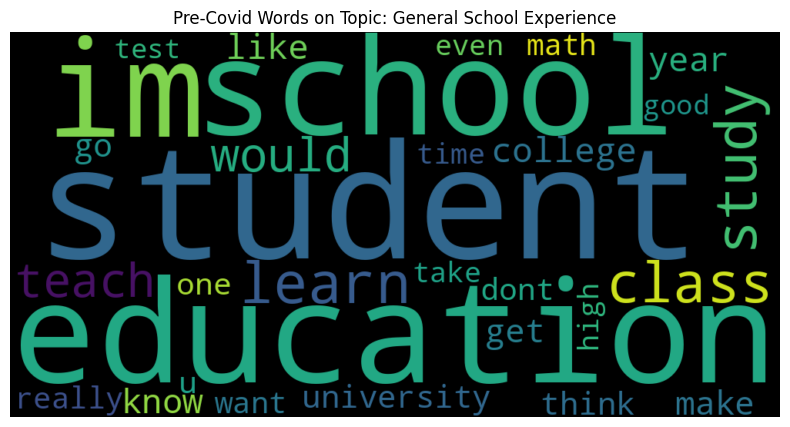

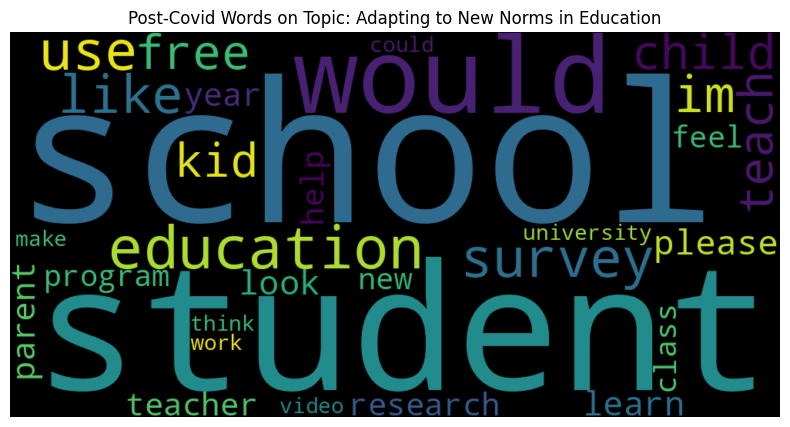

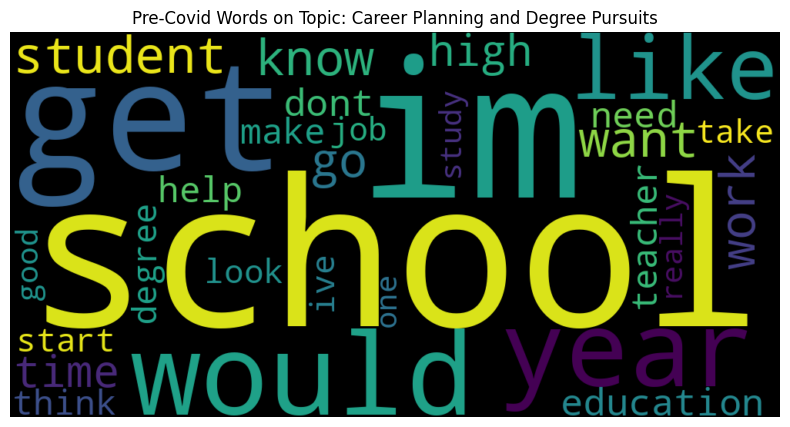

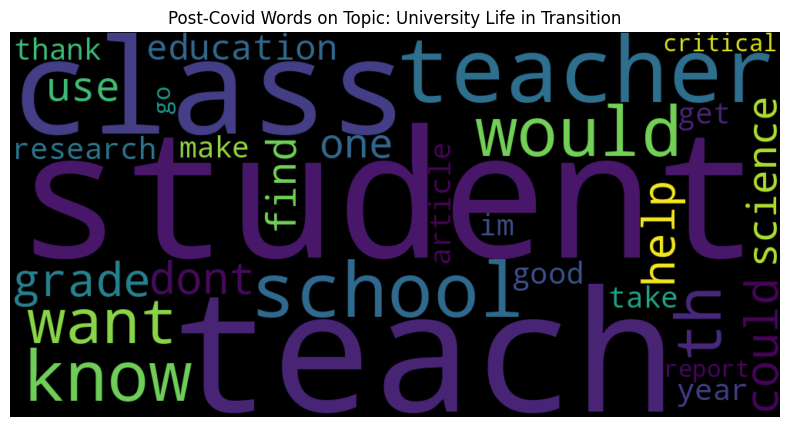

In [39]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(lda_model, topic_number, topic_title):
    plt.figure(figsize=(10, 5))
    wc = WordCloud(width=1000, height=500)
    words_freq = dict(lda_model.show_topic(topic_number, 30))
    cloud = wc.generate_from_frequencies(words_freq)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{topic_title}')
    plt.show()

# Plot word cloud for the topics
plot_word_cloud(pre_covid_lda_model, 0, 'Pre-Covid Words on Topic: General School Experience')
plot_word_cloud(post_covid_lda_model, 0, 'Post-Covid Words on Topic: Adapting to New Norms in Education')
plot_word_cloud(pre_covid_lda_model, 5, 'Pre-Covid Words on Topic: Career Planning and Degree Pursuits')
plot_word_cloud(post_covid_lda_model, 5, 'Post-Covid Words on Topic: University Life in Transition')


In [26]:
# Split the data into pre-COVID and post-COVID datasets
pre_covid_df = df[df['Year'] <= 2020]
post_covid_df = df[df['Year'] >= 2020]

# Check if the DataFrame is empty after filtering by year
if pre_covid_df.empty:
    raise ValueError("The pre-COVID dataframe is empty. Check your data filtering criteria.")
if post_covid_df.empty:
    raise ValueError("The post-COVID dataframe is empty. Check your data filtering criteria.")

# Function to prepare the corpus for LDA
def prepare_corpus(dataframe):
    texts = dataframe['combined_text']
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    return dictionary, corpus

# Prepare the corpus
pre_covid_dictionary, pre_covid_corpus = prepare_corpus(pre_covid_df)
post_covid_dictionary, post_covid_corpus = prepare_corpus(post_covid_df)

# Train LDA models
num_topics = 6
pre_covid_lda_model = models.LdaMulticore(pre_covid_corpus, num_topics=num_topics, id2word=pre_covid_dictionary, passes=10, workers=2)
post_covid_lda_model = models.LdaMulticore(post_covid_corpus, num_topics=num_topics, id2word=post_covid_dictionary, passes=10, workers=2)

# Display the topics
print("Pre-COVID topics:")
for idx, topic in pre_covid_lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

print("\nPost-COVID topics:")
for idx, topic in post_covid_lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))


Pre-COVID topics:
Topic: 0 
Words: 0.018*"im" + 0.017*"high" + 0.017*"job" + 0.014*"get" + 0.013*"work" + 0.012*"would" + 0.010*"education" + 0.010*"master" + 0.010*"year" + 0.009*"position"
Topic: 1 
Words: 0.019*"school" + 0.017*"student" + 0.012*"teacher" + 0.007*"make" + 0.007*"help" + 0.006*"like" + 0.006*"use" + 0.006*"say" + 0.005*"would" + 0.005*"get"
Topic: 2 
Words: 0.018*"university" + 0.016*"student" + 0.013*"education" + 0.010*"campus" + 0.008*"would" + 0.008*"im" + 0.007*"get" + 0.007*"high" + 0.007*"tour" + 0.006*"use"
Topic: 3 
Words: 0.011*"student" + 0.010*"work" + 0.009*"would" + 0.007*"education" + 0.006*"say" + 0.006*"high" + 0.006*"research" + 0.006*"one" + 0.005*"college" + 0.005*"use"
Topic: 4 
Words: 0.021*"student" + 0.011*"major" + 0.008*"degree" + 0.008*"affair" + 0.008*"career" + 0.008*"school" + 0.007*"education" + 0.007*"rate" + 0.006*"university" + 0.006*"wage"
Topic: 5 
Words: 0.016*"school" + 0.015*"im" + 0.012*"student" + 0.012*"year" + 0.011*"go" + 0

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


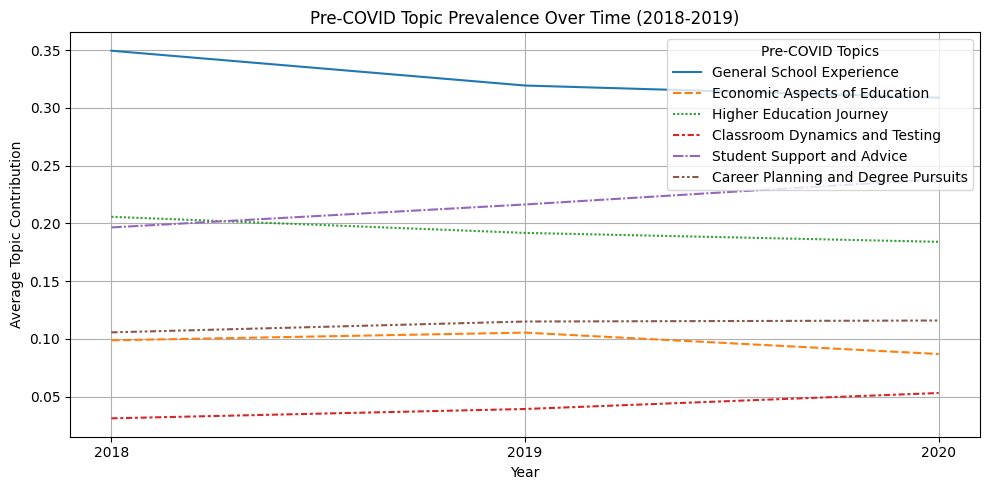

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


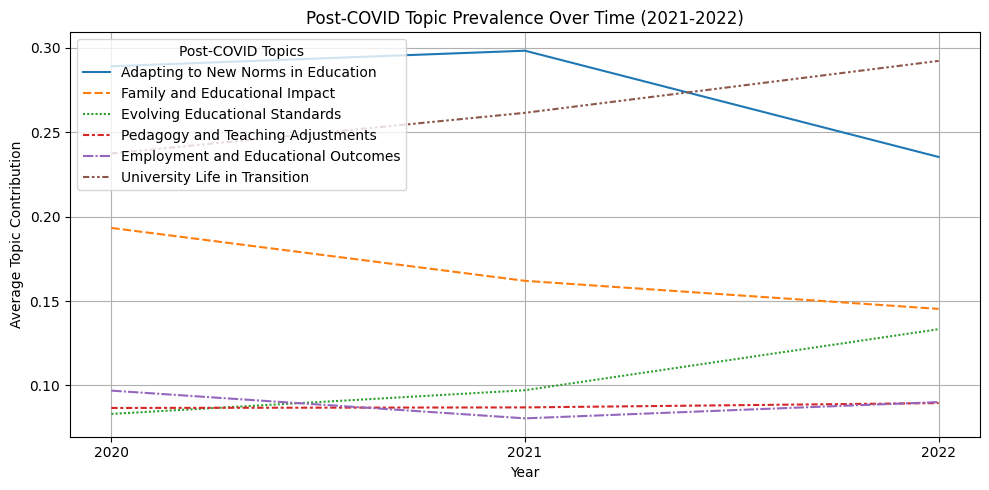

In [10]:
import seaborn as sns
from gensim import models

# Define topic labels
pre_covid_topic_labels = {
    0: "General School Experience",
    1: "Economic Aspects of Education",
    2: "Higher Education Journey",
    3: "Classroom Dynamics and Testing",
    4: "Student Support and Advice",
    5: "Career Planning and Degree Pursuits"
}

post_covid_topic_labels = {
    0: "Adapting to New Norms in Education",
    1: "Family and Educational Impact",
    2: "Evolving Educational Standards",
    3: "Pedagogy and Teaching Adjustments",
    4: "Employment and Educational Outcomes",
    5: "University Life in Transition"
}

# Function to get the topic distribution for each year
def get_topic_distribution(lda_model, corpus, dataframe, labels):
    data = []  # Initialize a list to collect data

    for i, row_list in enumerate(lda_model[corpus]):
        row = {label: 0 for label in labels.values()}  # Initialize all topics with 0 using labels
        for (topic_num, prop_topic) in row_list:
            row[labels[topic_num]] = prop_topic
        row['Year'] = dataframe.iloc[i]['Year']
        data.append(row)

    # Create DataFrame from collected data
    topics_over_time = pd.DataFrame(data)

    # Normalize the topics by year and return the result
    topics_over_time = topics_over_time.groupby('Year').mean().fillna(0)
    return topics_over_time

# Get topic distributions
pre_covid_distribution = get_topic_distribution(pre_covid_lda_model, pre_covid_corpus, pre_covid_df, pre_covid_topic_labels)
post_covid_distribution = get_topic_distribution(post_covid_lda_model, post_covid_corpus, post_covid_df, post_covid_topic_labels)

# Plotting Pre-COVID Data
plt.figure(figsize=(10, 5))
sns.lineplot(data=pre_covid_distribution)
plt.title('Pre-COVID Topic Prevalence Over Time (2018-2019)')
plt.xlabel('Year')
plt.ylabel('Average Topic Contribution')
plt.xticks(ticks=sorted(pre_covid_distribution.index.unique()), labels=sorted(pre_covid_distribution.index.unique()))
plt.legend(title='Pre-COVID Topics', loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting Post-COVID Data
plt.figure(figsize=(10, 5))
sns.lineplot(data=post_covid_distribution)
plt.title('Post-COVID Topic Prevalence Over Time (2021-2022)')
plt.xlabel('Year')
plt.ylabel('Average Topic Contribution')
plt.xticks(ticks=sorted(post_covid_distribution.index.unique()), labels=sorted(post_covid_distribution.index.unique()))
plt.legend(title='Post-COVID Topics', loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

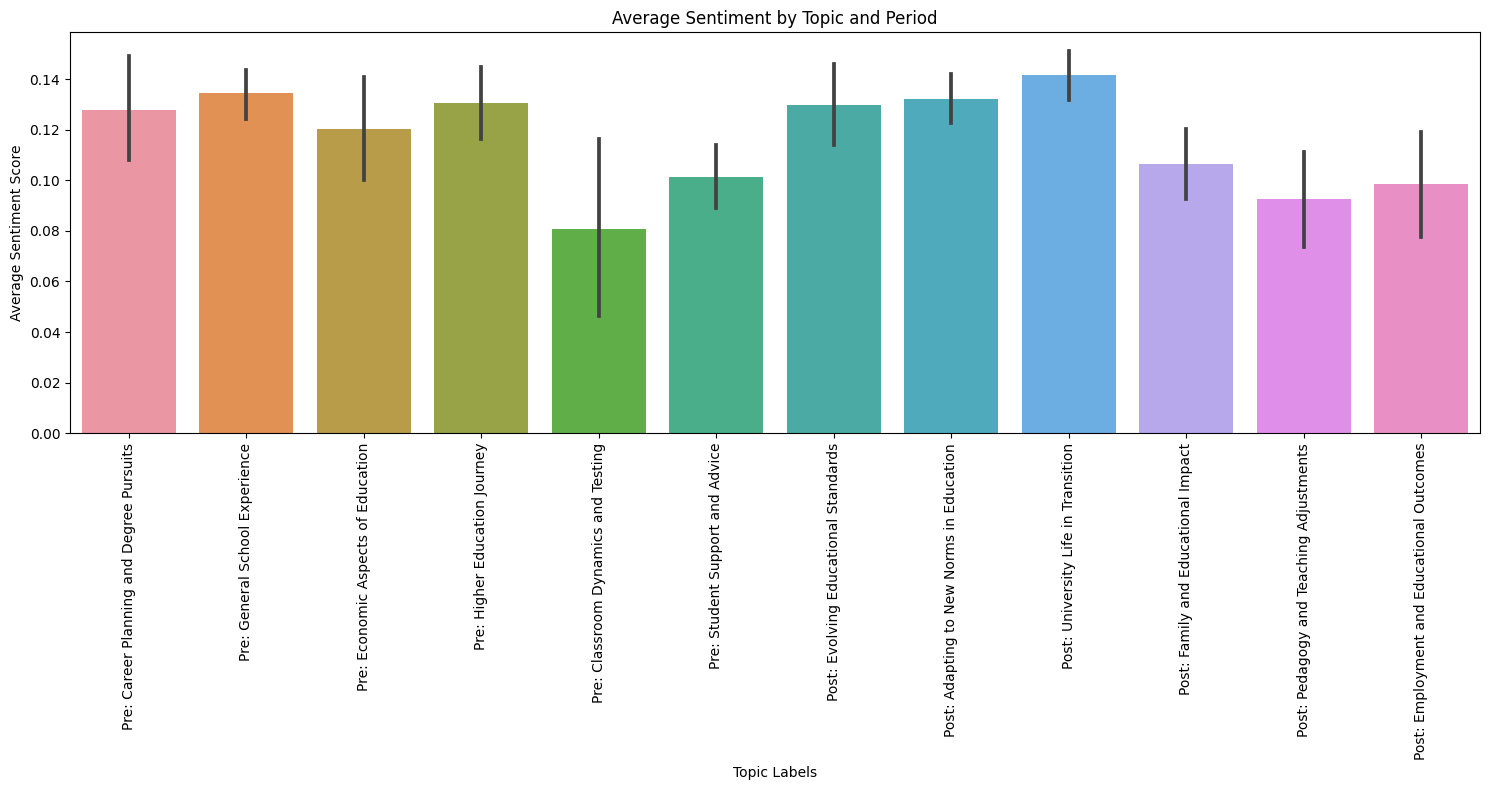

In [13]:
def format_topics_sentences(ldamodel, corpus, dataframe, labels):
    # Init output
    rows_list = []  # List to store each row data

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution, and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                # Append row to list
                rows_list.append([int(topic_num), round(prop_topic, 4), topic_keywords, labels[topic_num], dataframe.iloc[i]['Sentiment']])
            else:
                break

    # Convert list to DataFrame
    sent_topics_df = pd.DataFrame(rows_list, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Labels', 'Sentiment'])
    return sent_topics_df

# Labels dictionaries
pre_covid_topic_labels_dict = {
    0: "Pre: General School Experience",
    1: "Pre: Economic Aspects of Education",
    2: "Pre: Higher Education Journey",
    3: "Pre: Classroom Dynamics and Testing",
    4: "Pre: Student Support and Advice",
    5: "Pre: Career Planning and Degree Pursuits"
}

post_covid_topic_labels_dict = {
    0: "Post: Adapting to New Norms in Education",
    1: "Post: Family and Educational Impact",
    2: "Post: Evolving Educational Standards",
    3: "Post: Pedagogy and Teaching Adjustments",
    4: "Post: Employment and Educational Outcomes",
    5: "Post: University Life in Transition"
}

# Processing each dataset
pre_topics_df = format_topics_sentences(pre_covid_lda_model, pre_covid_corpus, pre_covid_df, pre_covid_topic_labels_dict)
post_topics_df = format_topics_sentences(post_covid_lda_model, post_covid_corpus, post_covid_df, post_covid_topic_labels_dict)

# Combine pre and post dataframes
combined_df = pd.concat([pre_topics_df, post_topics_df])

# Plot the sentiment analysis results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 8))
sns.barplot(x='Labels', y='Sentiment', data=combined_df)
plt.xticks(rotation=90)
plt.title('Average Sentiment by Topic and Period')
plt.ylabel('Average Sentiment Score')
plt.xlabel('Topic Labels')
plt.tight_layout()
plt.show()


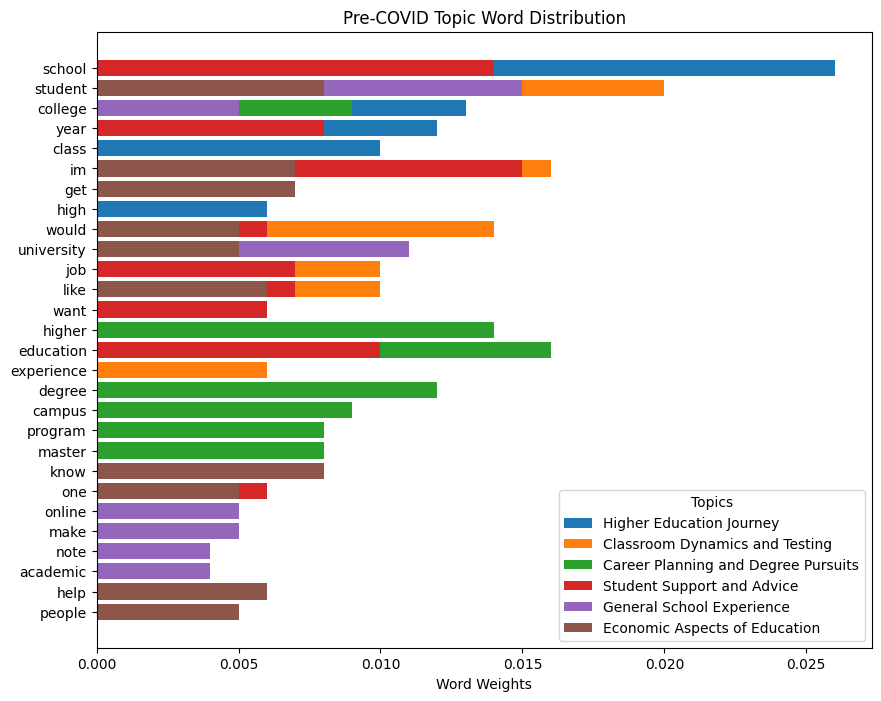

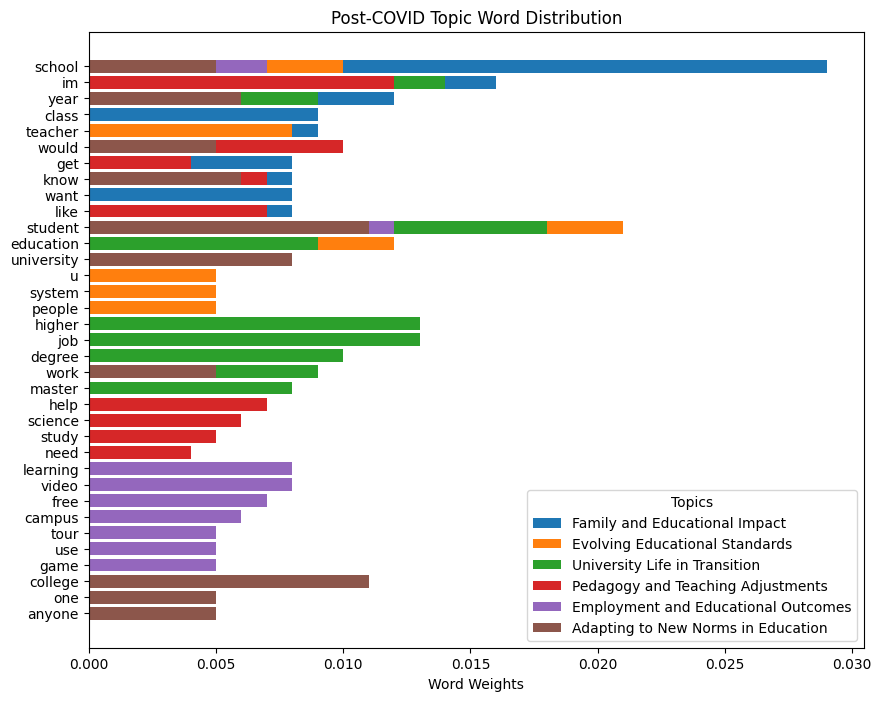

In [14]:
from collections import defaultdict

pre_covid_topics = {
    "General School Experience": {
        "student": 0.015, "university": 0.011, "online": 0.005, "im": 0.005,
        "college": 0.005, "make": 0.005, "would": 0.005, "like": 0.005,
        "note": 0.004, "academic": 0.004
    },
    "Economic Aspects of Education": {
        "student": 0.008, "know": 0.008, "get": 0.007, "im": 0.007,
        "like": 0.006, "help": 0.006, "would": 0.005, "one": 0.005,
        "university": 0.005, "people": 0.005
    },
    "Higher Education Journey": {
        "school": 0.026, "student": 0.014, "college": 0.013, "year": 0.012,
        "class": 0.010, "im": 0.008, "get": 0.007, "high": 0.006,
        "would": 0.006, "university": 0.006
    },
    "Classroom Dynamics and Testing": {
        "student": 0.020, "im": 0.016, "would": 0.014, "like": 0.010,
        "job": 0.010, "university": 0.008, "experience": 0.006, "education": 0.006,
        "want": 0.006, "higher": 0.006
    },
    "Student Support and Advice": {
        "im": 0.015, "school": 0.014, "education": 0.010, "year": 0.008,
        "know": 0.007, "like": 0.007, "job": 0.007, "want": 0.006,
        "one": 0.006, "would": 0.006
    },
    "Career Planning and Degree Pursuits": {
        "education": 0.016, "student": 0.015, "higher": 0.014, "degree": 0.012,
        "im": 0.011, "university": 0.010, "campus": 0.009, "college": 0.009,
        "program": 0.008, "master": 0.008
    }
}

post_covid_topics = {
    "Adapting to New Norms in Education": {
        "student": 0.011, "college": 0.011, "university": 0.008, "year": 0.006,
        "know": 0.006, "would": 0.005, "one": 0.005, "anyone": 0.005,
        "work": 0.005, "school": 0.005
    },
    "Family and Educational Impact": {
        "school": 0.029, "im": 0.016, "year": 0.012, "class": 0.009,
        "would": 0.009, "teacher": 0.009, "want": 0.008, "like": 0.008,
        "know": 0.008, "get": 0.008
    },
    "Evolving Educational Standards": {
        "student": 0.021, "education": 0.012, "school": 0.010, "university": 0.008,
        "teacher": 0.008, "would": 0.006, "like": 0.006, "u": 0.005,
        "system": 0.005, "people": 0.005
    },
    "Pedagogy and Teaching Adjustments": {
        "im": 0.012, "would": 0.010, "know": 0.007, "help": 0.007,
        "like": 0.007, "science": 0.006, "study": 0.005, "work": 0.005,
        "need": 0.004, "get": 0.004
    },
    "Employment and Educational Outcomes": {
        "student": 0.012, "video": 0.008, "learning": 0.008, "university": 0.007,
        "free": 0.007, "school": 0.007, "campus": 0.006, "game": 0.005,
        "use": 0.005, "tour": 0.005
    },
    "University Life in Transition": {
        "student": 0.018, "im": 0.014, "job": 0.013, "higher": 0.013,
        "degree": 0.010, "would": 0.009, "education": 0.009, "year": 0.009,
        "work": 0.009, "master": 0.008
    }
}

# Helper function to plot a bar chart for topics
def plot_topic_barchart(topics, title):
    # Flatten the topic word weights
    flat_data = defaultdict(list)
    for topic, words in topics.items():
        for word, weight in words.items():
            flat_data["Topic"].append(topic)
            flat_data["Word"].append(word)
            flat_data["Weight"].append(weight)

    # Create DataFrame for plotting
    df = pd.DataFrame(flat_data)

    # Sort the DataFrame by topic weights
    df.sort_values(by='Weight', ascending=False, inplace=True)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    for i, topic in enumerate(df['Topic'].unique()):
        subset = df[df['Topic'] == topic]
        ax.barh(subset['Word'], subset['Weight'], label=topic)

    ax.set_xlabel('Word Weights')
    ax.set_title(title)
    ax.legend(title='Topics')
    plt.gca().invert_yaxis()  # To display the heaviest words at the top
    plt.show()

# Plot for Pre-COVID topics
plot_topic_barchart(pre_covid_topics, "Pre-COVID Topic Word Distribution")

# Plot for Post-COVID topics
plot_topic_barchart(post_covid_topics, "Post-COVID Topic Word Distribution")


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


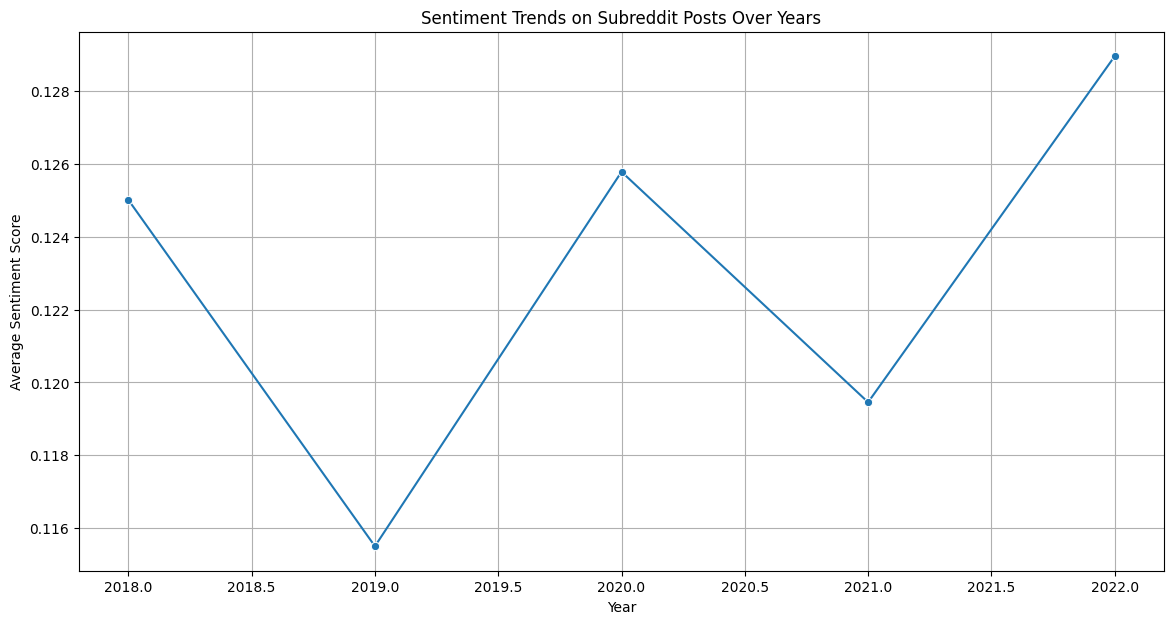

In [15]:
# Map sentiment to numerical values
sentiment_mapping = {
    'positive': 1,
    'neutral': 0,
    'negative': -1
}

# Group by year and get the average sentiment score per year
sentiment_trends = df.groupby('Year')['Sentiment'].mean().reset_index()

# Plot trends
plt.figure(figsize=(14, 7))
sns.lineplot(x='Year', y='Sentiment', data=sentiment_trends, marker='o')
plt.title('Sentiment Trends on Subreddit Posts Over Years')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.show()


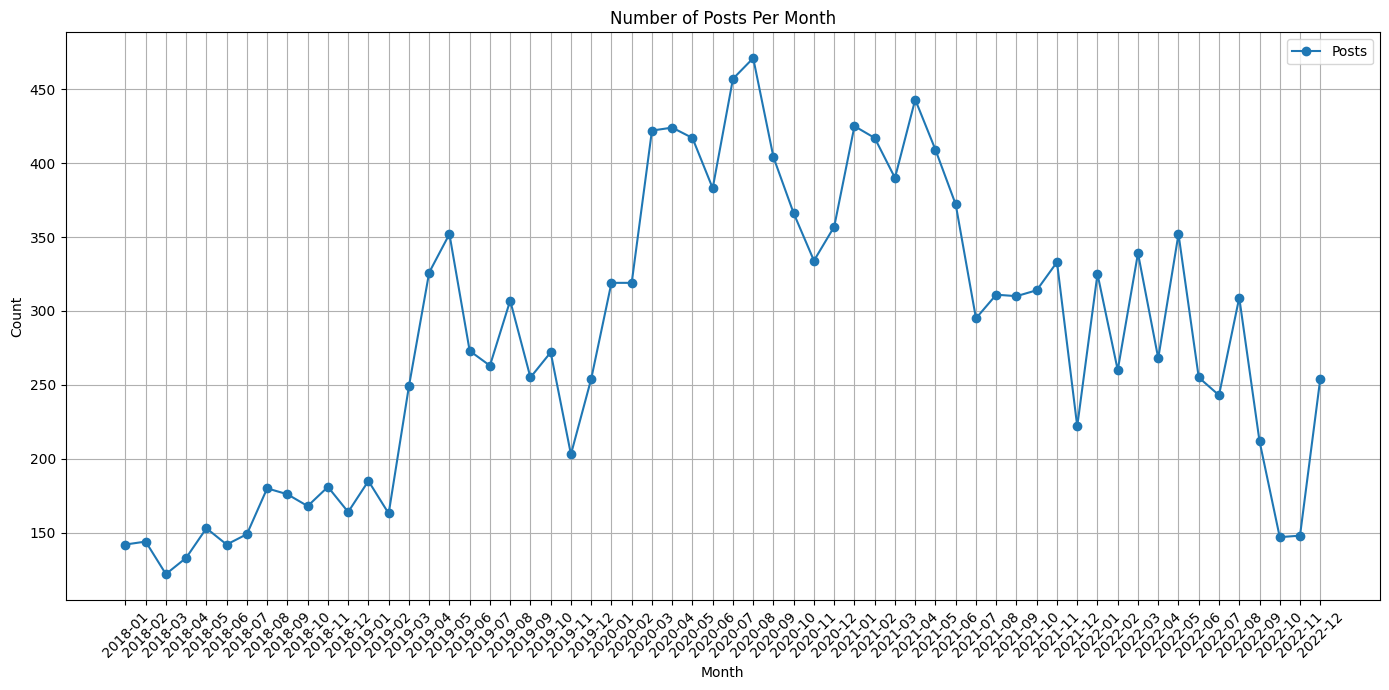

In [20]:
# Datetime entries
df_valid_posts = df[df['created_utc_sub'].notna()]
df_valid_comments = df[df['created_utc_com'].notna()]

# Resample to get all counts per month
posts_per_month = df_valid_posts['created_utc_sub'].dt.to_period('M').value_counts().sort_index()
comments_per_month = df_valid_comments['created_utc_com'].dt.to_period('M').value_counts().sort_index()
combined_per_month = posts_per_month + comments_per_month

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(combined_per_month.index.astype(str), combined_per_month.values, label='Posts', marker='o')
plt.title('Number of Posts Per Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
